# Imports

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

import pandas as pd

# from matplotlib.colors import Lognorm
from scipy.integrate import simps
from time import time
import warnings
warnings.simplefilter("ignore")

Populating the interactive namespace from numpy and matplotlib


In [2]:
from ipywidgets import interact
import seaborn as sns
sns.set(palette='colorblind', style='whitegrid')
sns.set_style({'font.family': ['serif']})
from matplotlib.colors import LogNorm, SymLogNorm

In [3]:
from scipy.optimize import minimize
from scipy.interpolate import InterpolatedUnivariateSpline as ius
from scipy.interpolate import interp1d
from scipy import stats
from sklearn.metrics.pairwise import pairwise_kernels

from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process import kernels
RBF = kernels.RBF
WhiteKernel = kernels.WhiteKernel

In [4]:
sys.path.append('../cf_analysis/')
import tools

import glearn
from rscm import RSCM
# from cf_analysis import pcalearn
from sklearn.decomposition import PCA
from svdanalysis import SVDlearn
import synth, kde, pcalearn
from pcalearn import PCAYJ

# from cf_analysis import kde
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.base import BaseEstimator, RegressorMixin
KernelRegression = kde.KernelRegression

import yjtransform as yjt


# Setup

In [5]:

class GetObject(object):
    def __init__(self, *initial_data, **kwargs):
        for dictionary in initial_data:
            for key in dictionary:
                setattr(self, key, dictionary[key])
        for key in kwargs:
            setattr(self, key, kwargs[key])           
            
    

In [6]:


# years = t           

data = pd.read_csv('../basque.csv')
years = data['year'].unique()
xplot = years.copy()            
T0 = np.where(years == 1970)[0][0]
years = years[:2*T0]
gdp = data['gdpcap'].values.reshape(18, -1)
gdp = gdp[1:, :2*T0]
treated = gdp[-2]
rr = data['regionname'].unique()[-2]
controls = np.append(gdp[:-2], gdp[-1:], axis=0)

X = gdp.copy()
N, T = X.shape[0], X.shape[1]
t = np.arange(T)
itreated = 15
xplot = years.copy()

tools.approximate_rank(controls - controls.mean(axis=0), 0.999)

5

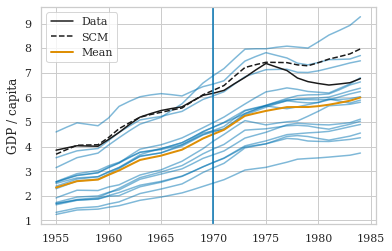

In [7]:
plt.plot(years, controls.T, 'C0', alpha=0.5)
plt.plot(years, treated, 'k', label='Data')
plt.plot(years, synth.fit(controls, treated, T0)[0],'k--', label='SCM')
plt.plot(years, controls.mean(axis=0), 'C1', lw=2, label='Mean')
# plt.plot(pcad.inverse_transform(pcad.transform((treated-Xrawmean).reshape(1, -1))).flatten()+Xrawmean)
# plt.plot(Xraw[4]+Xrawmean)
# plt.plot(X[4]+Xrawmean)
plt.ylabel('GDP / capita')
plt.axvline(years[T0])
plt.legend()
plt.show()



# SCM

In [8]:

scmfits =  {}
for ii, ss in enumerate(np.arange(N)):
    xx = np.concatenate([X[:ii], X[ii+1:]])
    yy = X[ii]
    means = xx.mean(axis=0)
    ##
    ##
    X1 = (xx - means)[:, :T0]
    X2 = (xx - means)[:, T0:]
    Y1 = (yy-means)[:T0]
    Y2 = (yy-means)[T0:]
    yp, wts = synth.fit(xx, yy, T0)
        
    scmfits[ss] = GetObject(controls=xx, treated=yy, pred=yp, wts=wts)
    
    
    

scmfitsres =  {}
for ii, ss in enumerate(np.arange(N)):
    xxc = np.concatenate([X[:ii], X[ii+1:]])
    yyc = X[ii]
    means = xxc.mean(axis=0)
    ##
    ##
    mmx, mmy = xxc[:, :T0].mean(axis=1), yyc[:T0].mean()
    xx = xxc - mmx.reshape(-1, 1)
    yy = yyc - mmy
    
    yp, wts = synth.fit(xx, yy, T0)    
    yp += mmy
    
    scmfitsres[ss] = GetObject(controls=xxc, treated=yyc, pred=yp, wts=wts)    

# Fourier Anlaysis

In [9]:
# diff = controls[:, :T0].mean(axis=1).reshape(-1, 1)
# difft = treated[:T0].mean()

# gl = glearn.GLearn(controls-diff, padl=T, padr=T, stdscale=False, normalization=None)
# # glpred, glerr, glcov = gl.fit(treated, 15)
# glpred, glerr, glcov = gl.fit(treated - difft, 15)
# glpred += difft

# bins = 20 
# normed = False
# # plt.hist((controls - means).flatten(), bins=bins, normed=normed, label='Data', alpha=0.6, color='C0')
# plt.hist((gl.controls-means).flatten(), bins=bins, normed=normed, label='Data', alpha=0.6, color='C0')
# plt.hist(gl.controlsg.flatten(), bins=bins, normed=normed, label='Transformed', alpha=0.6, color='C1')
# plt.legend()
# plt.show()
# # plt.hist(gca.controls.flatten())
# plt.plot(years, treated,  'k', label='Data')
# plt.errorbar(years, glpred, glerr, label='GL')
# plt.plot(years, synth.fit(controls, treated, T0)[0], label='SCM')
# plt.plot(years, means,'gray', label='Mean')
# plt.legend()

In [10]:

glfits =  {}
for ii, ss in enumerate(np.arange(N)):
    xx = np.concatenate([X[:ii], X[ii+1:]])
    yy = X[ii]
    means = xx.mean(axis=0)
    diff, difft = xx[:, :T0].mean(axis=1).reshape(-1, 1), yy[:T0].mean()
    ##
    ##
    gl = glearn.GLearn(xx-diff, padl=T, padr=T, stdscale=False)
    yp, err, cov = gl.fit(yy-difft, T0)
    yp += difft
    glfits[ss] = GetObject(controls=xx, treated=yy, pred=yp, err=err, cov=cov)
    
    


scmfits 0.6521917781668111
scmfitsres 0.5954710261714631
glfits 0.6606862667144636


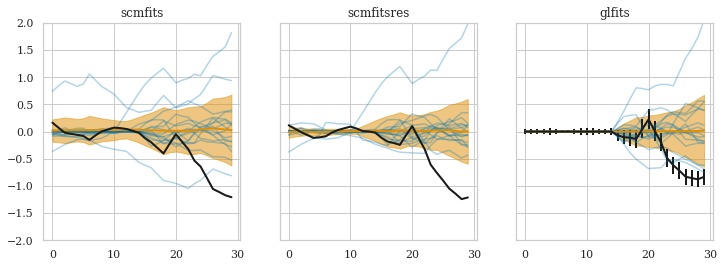

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)

xplot = np.arange(X.shape[1])

titles = 'scmfits, scmfitsres, glfits'
titles = titles.split(', ')
for j, fits in enumerate([scmfits, scmfitsres, glfits]):
    tmp = []
    axis = ax.flatten()[j]
    for ii in range(X.shape[0]): 
        tmp.append(fits[ii].treated - fits[ii].pred)
        axis.plot(xplot, tmp[-1], 'C0', alpha=0.3)
    tmp = np.array(tmp)
    mmean, sstd = tmp.mean(axis=0), tmp.std(axis=0)
    print(titles[j], sstd[-1])
    axis.plot(xplot, mmean, 'C1', lw=2)
    try: axis.errorbar(xplot, tmp[itreated], fits[itreated].err, color='k', lw=2)
    except: axis.plot(xplot, tmp[itreated], 'k', lw=2)
    axis.fill_between(xplot, mmean - sstd, mmean + sstd, alpha=0.5, color='C1')
    axis.set_title(titles[j])
    axis.set_ylim(-2, 2)
#     axis.set_ylim(-50, 50)

#     axis.set_ylim(-50, 50)

# PCA

2
[0.50229455 1.17545769]


<ErrorbarContainer object of 3 artists>

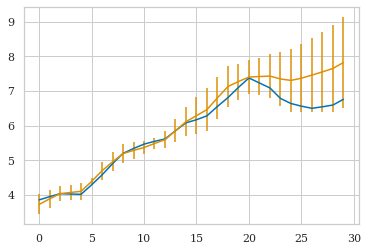

In [12]:
xx = controls.copy()
means = xx.mean(axis=0)
yy = treated.copy()
xplot = np.arange(yy.size)
xx -= means
yy -= means
mmx = xx[: , :T0].mean(axis=1)
mmy = yy[:T0].mean()
xx -= mmx.reshape(-1, 1)
yy -= mmy
##
i = 0 

##t : Threshold of variance that needs to be accounted
ncomp = tools.approximate_rank(xx-means , t=0.999)
# ncomp = 2
print(ncomp)


##
pcl = pcalearn.PCAlearn(xx, ncomp, stdscale=False, normalization='center')
pca = pcl.pca
errpca = pca.get_covariance().diagonal()**0.5
ypca, err,  pp = pcl.fitanalytic(yy.flatten(), T0, regwt=None, verbose=True)
print(pp) 
ypca += means
ypca += mmy
plt.plot(xplot, treated, label='data')
plt.errorbar(xplot, ypca , err)


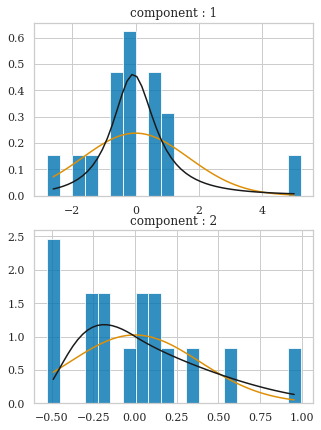

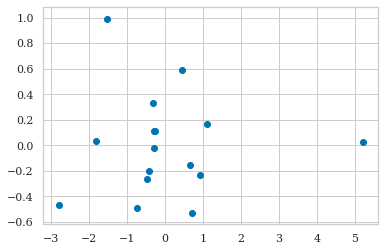

In [13]:
#Visualize the distribtuion of PCA components for control units
#And do a YJ transform on them to Gaussianize 


nbins = 20 
normed = True
ncomp = 2
xxt = pca.transform(pcl.normalize(xx))
tt = xxt[:, 1].copy()
ptt = yjt.get_transform(tt)
ttx = np.linspace(tt.min(), tt.max())
qq = yjt.getpdf(ttx, ptt)

# y_, x_, _ = plt.hist(yjt.transform(tt,  ptt).flatten(), alpha=0.7, bins=nbins, density=True)
# x_ = (x_[1:] + x_[:-1])/2.
# pp = tools.fitgausspdf(yjt.transform(tt,  ptt).flatten(), normalized=True, verbose=0)    


fig, axar = plt.subplots(2, ncomp//2, figsize= (ncomp//2*5, 7))

ax = axar.flatten()
for ia in range(ncomp):
    if ia >= ax.size: break
    if ia > ncomp: break    
    y_, x_, _ = ax[ia].hist(xxt.T[ia], bins=nbins, density=normed, alpha=0.8)
    x_ = (x_[1:] + x_[:-1])/2.

    xplot = np.linspace(x_.min(), x_.max())
    ppg = tools.fitgausspdf(xxt.T[ia], normalized=True, verbose=0)    
    ax[ia].plot(xplot, tools.logpdf_gauss(xplot, *ppg, rety=True, normalized=True), 'C1')
    ax[ia].set_title("component : %d"%(ia+1))
    pyj = yjt.get_transform(xxt.T[ia])
    qq = yjt.getpdf(xplot, pyj)
    ax[ia].plot(xplot, qq, 'k')
    
plt.show()
plt.scatter(xxt[:, 0], xxt[:, 1])
plt.show()

In [14]:
##Do the fitting for all units


thresh = 0.99

    
##Simple PCA regression
pcafits = {}

for ii, ss in enumerate(np.arange(N)):
    xx = np.concatenate([X[:ii], X[ii+1:]])
    yy = X[ii]
    means = xx.mean(axis=0)
    ncpca = tools.approximate_rank(xx-means, t=thresh)
    if not ii: print(ncpca)
    if ncpca  == 1: ncpca += 1
    ##
    pcl = pcalearn.PCAlearn(xx, ncpca, stdscale=False, normalization='center', whiten=False)
    pca = pcl.pca
    noise = pca.explained_variance_.sum()*(1/pca.explained_variance_ratio_.sum()-1)
    ##
    ypca2, err, pp2 = pcl.fitanalytic(yy.flatten(), T0,  regwt=None, verbose=False, noise=noise)
    pcafits[ss] = GetObject(controls=xx, treated=yy, pred=ypca2, pcl=pcl, fitp=pp2, nc=ncpca, err=err)




##Similar to PCA regression but without centering/normalizing the the data
svdfits = {}

for ii, ss in enumerate(np.arange(N)):
    xx = np.concatenate([X[:ii], X[ii+1:]])
    yy = X[ii]
    means = xx.mean(axis=0)
    ncsvd = tools.approximate_rank(xx, t=thresh)
    if not ii: print(ncsvd)
    if ncsvd  == 1: ncsvd += 1
    ##
    svl = SVDlearn(xx, stdscale=False, normalization=None)
    yp, pp = svl.fit(yy.flatten(), T0, ncsvd, verbose=False)
    svdfits[ss] = GetObject(controls=xx, treated=yy, svl=svl, pred=yp, fitp=pp, nc=ncsvd)

    
    
    
##PCA regression with L2regularization of weights, search optimal weighting
pcafitsreg = {}

for ii, ss in enumerate(np.arange(N)):
    xx = np.concatenate([X[:ii], X[ii+1:]])
    yy = X[ii]
    means = xx.mean(axis=0)
    ncpca = tools.approximate_rank(xx-means, t=thresh)
    ##
    pcl = pcalearn.PCAlearn(xx, ncpca, stdscale=False, normalization='center')
    ##
    ypca2, yerr, pp2, regwt = pcl.fitanalytic(yy.flatten(), T0, regwt=np.logspace(-5, 2, 100), verbose=0, dT=3, retreg=True)
    pcafitsreg[ss] = GetObject(controls=xx, treated=yy, pred=ypca2, err=yerr, pcl=pcl, fitp=pp2, nc=ncpca, regwt=regwt)


##PCA regression with L2regularization of weights, search optimal weighting and noise in the pre-intervention data due to finite PCA components
pcafitsregnoise = {}

for ii, ss in enumerate(np.arange(N)):
    xx = np.concatenate([X[:ii], X[ii+1:]])
    yy = X[ii]
    means = xx.mean(axis=0)
    ncpca = tools.approximate_rank(xx-means, t=thresh)
    ##
    pcl = pcalearn.PCAlearn(xx, ncpca, stdscale=False, normalization='center')
    pca = pcl.pca
# #     noise = (xx - pcl.unnormalize(pca.inverse_transform(pca.transform(pcl.normalize(xx)))))[:, :T0].std()**2
#     noise = xx[:, :T0].std()**2
    noise = pca.explained_variance_.sum()*(1/pca.explained_variance_ratio_.sum()-1)
    ##
    ypca2, yerr, pp2, regwt = pcl.fitanalytic(yy.flatten(), T0, regwt=np.logspace(-5, 2, 100), verbose=0, dT=3, retreg=True, noise=noise)
    pcafitsregnoise[ss] = GetObject(controls=xx, treated=yy, pred=ypca2, err=yerr, pcl=pcl, fitp=pp2, nc=ncpca, regwt=regwt)

    
    

2
1


<ErrorbarContainer object of 3 artists>

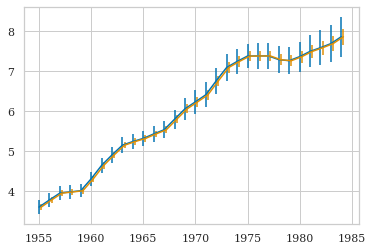

In [15]:
ii = itreated
xplot = years.copy()
plt.errorbar(xplot, pcafitsreg[ii].pred, pcafitsreg[ii].err )
plt.errorbar(xplot + 0.2, pcafitsregnoise[ii].pred, pcafitsregnoise[ii].err)

# PCAYJ

In [16]:

def pcaregfit(pca, yy, T0, alpha=None, sigma=None, means=None, noise=1.):
    yy2 = yy.copy()
    if means is not None: yy2 -= means
    yy2[T0:] = 0 
    phi = pca.components_.copy()
    phi[:, T0:] = 0 

    if sigma is not None: Sigmainv = np.diag(np.array(sigma)**-2)
    elif alpha is not None: Sigmainv =  alpha*np.identity(pca.components_.shape[0])
    A = np.dot(phi, phi.T)/noise + Sigmainv
    Ainv =  np.linalg.pinv(A)
    w = np.dot(np.dot(Ainv, phi), yy2)/noise
    ypred = np.dot(pca.components_.T, w)
    if means is not None: ypred += means
    cov = np.dot(np.dot(pca.components_.T, Ainv) , pca.components_)
    err = cov.diagonal()**0.5
    return ypred, err, w
    # print(w, ypred[1])



##Simple PCA fits with YJ transform/Gaussianize the weights and use that as prior for regularization
pcafitsyj = {}

for ii, ss in enumerate(np.arange(N)):
    xx = np.concatenate([X[:ii], X[ii+1:]])
    yy = X[ii]
    means = xx.mean(axis=0)
    ncpca = tools.approximate_rank(xx-means, t=thresh)
    ##
    pcl = PCAYJ(xx, ncpca, stdscale=False, normalization='center', whiten=False)
    sigma = np.array([tools.fitgausspdf(i)[1] for i in pcl.pca.transform(pcl.normalize(xx)).T])
    ##
    method = 'bfgs'
    ypca2, pp2 = pcl.fit(yy.flatten(), T0, method=method)
    _, err, _, = pcl.fitanalytic(yy.flatten(), T0, sigma=sigma)
    pcafitsyj[ss] = GetObject(controls=xx, treated=yy, pred=ypca2, pcl=pcl, fitp=pp2, nc=ncpca, err=err)


##Simple PCA fits with YJ transform/Gaussianize the weights and use that as prior for regularization,
#and noise in the pre-intervention data due to finite PCA components
pcafitsyjnoise = {}

for ii, ss in enumerate(np.arange(N)):
    xx = np.concatenate([X[:ii], X[ii+1:]])
    yy = X[ii]
    means = xx.mean(axis=0)
    ncpca = tools.approximate_rank(xx-means, t=thresh)
    ##
    pcl = PCAYJ(xx, ncpca, stdscale=False, normalization='center', whiten=False)
    pca = pcl.pca
    sigma = np.array([tools.fitgausspdf(i)[1] for i in pcl.pca.transform(pcl.normalize(xx)).T])
#     noise = xx[:, :T0].std()**2
    noise = pca.explained_variance_.sum()*(1/pca.explained_variance_ratio_.sum()-1)
    ##
    method = 'bfgs'
    ypca2, pp2 = pcl.fit(yy.flatten(), T0, method=method, noise=noise)
    _, err, _, = pcl.fitanalytic(yy.flatten(), T0, sigma=sigma, noise=noise)    
    pcafitsyjnoise[ss] = GetObject(controls=xx, treated=yy, pred=ypca2, pcl=pcl, fitp=pp2, nc=ncpca, noise=noise, err=err)

    

../cf_analysis/pcalearn.py:297: OptimizeWarning: Unknown solver options: ftol, maxfun
  elif method == 'bfgs' : pp = minimize(_loss, p0, method='BFGS', options={'maxiter':50000, 'ftol': 1e-10, 'gtol': 1e-8, 'eps': 1e-10, 'maxfun': 50000})
../cf_analysis/pcalearn.py:297: OptimizeWarning: Unknown solver options: ftol, maxfun
  elif method == 'bfgs' : pp = minimize(_loss, p0, method='BFGS', options={'maxiter':50000, 'ftol': 1e-10, 'gtol': 1e-8, 'eps': 1e-10, 'maxfun': 50000})
../cf_analysis/pcalearn.py:297: OptimizeWarning: Unknown solver options: ftol, maxfun
  elif method == 'bfgs' : pp = minimize(_loss, p0, method='BFGS', options={'maxiter':50000, 'ftol': 1e-10, 'gtol': 1e-8, 'eps': 1e-10, 'maxfun': 50000})
../cf_analysis/pcalearn.py:297: OptimizeWarning: Unknown solver options: ftol, maxfun
  elif method == 'bfgs' : pp = minimize(_loss, p0, method='BFGS', options={'maxiter':50000, 'ftol': 1e-10, 'gtol': 1e-8, 'eps': 1e-10, 'maxfun': 50000})
../cf_analysis/pcalearn.py:297: OptimizeWarn

scmfits 0.6521917781668111
scmfitsres 0.5954710261714631
pcafits 0.5712906307449387
svdfits 0.6339146349583686
pcafitsreg 0.5100034413660451
pcafitsregnoise 0.5092846933682278
pcafitsyj 0.5343210127829034
pcafitsyjnoise 0.545306159429999


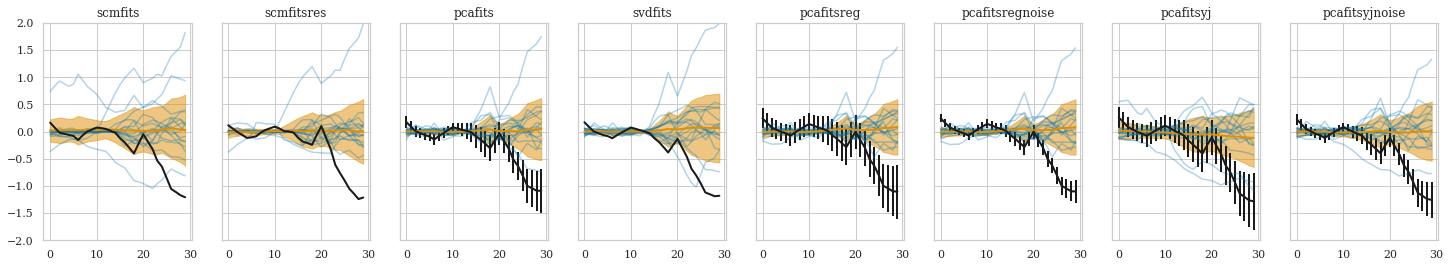

In [17]:
fig, ax = plt.subplots(1, 8, figsize=(25, 4), sharex=True, sharey=True)

xplot = np.arange(X.shape[1])

titles = ['scmfits', 'scmfitsres',  'pca99', 'pcafits95', 'pcafits99reg', 'pcafitsyj99', 'pcafitsyj95', 'svdfits99']
titles = 'scmfits, scmfitsres, pcafits, svdfits, pcafitsreg, pcafitsregnoise, pcafitsyj, pcafitsyjnoise'
titles = titles.split(', ')
for j, fits in enumerate([scmfits, scmfitsres, pcafits, svdfits, pcafitsreg, pcafitsregnoise, pcafitsyj, pcafitsyjnoise]):
    tmp = []
    axis = ax.flatten()[j]
    for ii in range(X.shape[0]): 
        tmp.append(fits[ii].treated - fits[ii].pred)
        axis.plot(xplot, tmp[-1], 'C0', alpha=0.3)
    tmp = np.array(tmp)
    mmean, sstd = tmp.mean(axis=0), tmp.std(axis=0)
    print(titles[j], sstd[-1])
    axis.plot(xplot, mmean, 'C1', lw=2)
    try: axis.errorbar(xplot, tmp[itreated], fits[itreated].err, color='k', lw=2)
    except: axis.plot(xplot, tmp[itreated], 'k', lw=2)
    axis.fill_between(xplot, mmean - sstd, mmean + sstd, alpha=0.5, color='C1')
    axis.set_title(titles[j])
    axis.set_ylim(-2, 2)
#     axis.set_ylim(-50, 50)



## Vary comp

In [18]:

xx = controls.copy()
means = xx.mean(axis=0)*1
yy = treated.copy()
xplot = np.arange(yy.size)
xx -= means
yy -= means
# mmx = xx[: , :T0].mean(axis=1)*0
# mmy = yy[:T0].mean()*0
# xx -= mmx.reshape(-1, 1)
# yy -= mmy
##
pcapreds = {}
pcapredsyj = {}
pcapredsreg = {}
pcapredsyjnoise = {}
pcapredsregnoise = {}
svdpreds = {}

i = 0 
for ncomp in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    pcl = pcalearn.PCAlearn(xx, ncomp, stdscale=False, normalization='center')
    pca = pcl.pca
    noise = pca.explained_variance_.sum()*(1/pca.explained_variance_ratio_.sum()-1)
    ypca, err, pp = pcl.fitanalytic(yy.flatten(), T0, regwt=None, verbose=True, noise=noise)
    ypca += means
    pcapreds[ncomp] = GetObject(controls=xx+means, treated=yy+means, pred=ypca, pcl=pcl, fitp=pp, nc=ncomp, err=err)
    
    pcl = pcalearn.PCAlearn(xx, ncomp, stdscale=False, normalization='center')
    ypca, err, pp, regwt = pcl.fitanalytic(yy.flatten(), T0, regwt=np.logspace(-5, 2), verbose=True, retreg=True)
    ypca += means
    pcapredsreg[ncomp] = GetObject(controls=xx+means, treated=yy+means, pred=ypca, pcl=pcl, fitp=pp, nc=ncomp, err=err, regwt=regwt)

    #
    pcl = PCAYJ(xx, ncomp, stdscale=False, normalization='center', whiten=False)
    sigma = np.array([tools.fitgausspdf(i)[1] for i in pcl.pca.transform(pcl.normalize(xx)).T])
    ypcayj, ppyj = pcl.fit(yy.flatten(), T0, method='bfgs')
    _, err, _, = pcl.fitanalytic(yy.flatten(), T0, sigma=sigma)
    pcapredsyj[ncomp] = GetObject(controls=xx+means, treated=yy+means, pred=ypcayj+means, pcl=pcl, fitp=ppyj, nc=ncomp, err=err)
    
#     noise = xx[:, :T0].std()
    pcl = pcalearn.PCAlearn(xx, ncomp, stdscale=False, normalization='center')
    pca = pcl.pca
    noise = pca.explained_variance_.sum()*(1/pca.explained_variance_ratio_.sum()-1)
    ypca, err, pp,regwt = pcl.fitanalytic(yy.flatten(), T0, regwt=np.logspace(-5, 2), verbose=True, noise=noise, retreg=True)
    ypca += means
    pcapredsregnoise[ncomp] = GetObject(controls=xx+means, treated=yy+means, pred=ypca, pcl=pcl, fitp=pp, nc=ncomp, err=err, regwt=regwt, noise=noise)

    #
    pcl = PCAYJ(xx, ncomp, stdscale=False, normalization='center', whiten=False)
    pca = pcl.pca
    noise = pca.explained_variance_.sum()*(1/pca.explained_variance_ratio_.sum()-1)
    sigma = np.array([tools.fitgausspdf(i)[1] for i in pcl.pca.transform(pcl.normalize(xx)).T])
    ypcayj, ppyj = pcl.fit(yy.flatten(), T0, method='bfgs', noise=noise)
    _, err, _, = pcl.fitanalytic(yy.flatten(), T0, sigma=sigma, noise=noise)
    pcapredsyjnoise[ncomp] = GetObject(controls=xx+means, treated=yy+means, pred=ypcayj+means, pcl=pcl, fitp=ppyj, nc=ncomp, err=err, noise=noise)

#     pcl = pcalearn.PCAlearn(xx, ncomp, stdscale=False, normalization='center')
# #     noise = (xx - pcl.unnormalize(pcl.pca.inverse_transform(pcl.pca.transform(pcl.normalize(xx)))))[:, :T0].std()**2
#     pca = pcl.pca
#     noise = pca.explained_variance_.sum()*(1/pca.explained_variance_ratio_.sum()-1)
#     ypca, err, pp,regwt = pcl.fitanalytic(yy.flatten(), T0, regwt=np.logspace(-5, 0), verbose=True, noise=noise, retreg=True)
#     ypca += means
#     pcapredsregnoisepca[ncomp] = GetObject(controls=xx+means, treated=yy+means, pred=ypca, pcl=pcl, fitp=pp, nc=ncomp, err=err, regwt=regwt, noise=noise)

#     #
#     pcl = PCAYJ(xx, ncomp, stdscale=False, normalization='center', whiten=False)
#     sigma = np.array([tools.fitgausspdf(i)[1] for i in pcl.pca.transform(pcl.normalize(xx)).T])
#     noise = (xx - pcl.unnormalize(pcl.pca.inverse_transform(pcl.pca.transform(pcl.normalize(xx)))))[:, :T0].std()**2
#     ypcayj, ppyj = pcl.fit(yy.flatten(), T0, method='bfgs', noise=noise)
#     _, err, _, = pcl.fitanalytic(yy.flatten(), T0, sigma=sigma, noise=noise)
#     pcapredsyjnoisepca[ncomp] = GetObject(controls=xx+means, treated=yy+means, pred=ypcayj+means, pcl=pcl, fitp=ppyj, nc=ncomp, err=err, noise=noise)

    ##
    svl = SVDlearn(controls.copy(), stdscale=False, normalization=None)
    yp, pp = svl.fit(treated.copy(), T0, ncomp, verbose=False)
    svdpreds[ncomp] = GetObject(controls=controls.copy(), treated=treated.copy(), svl=svl, pred=yp, fitp=pp, nc=ncomp)


min rms is at reg = 1.931e+00
min rms is at reg = 1.389e+00
min rms is at reg = 1.000e+00


../cf_analysis/pcalearn.py:297: OptimizeWarning: Unknown solver options: ftol, maxfun
  elif method == 'bfgs' : pp = minimize(_loss, p0, method='BFGS', options={'maxiter':50000, 'ftol': 1e-10, 'gtol': 1e-8, 'eps': 1e-10, 'maxfun': 50000})
../cf_analysis/pcalearn.py:297: OptimizeWarning: Unknown solver options: ftol, maxfun
  elif method == 'bfgs' : pp = minimize(_loss, p0, method='BFGS', options={'maxiter':50000, 'ftol': 1e-10, 'gtol': 1e-8, 'eps': 1e-10, 'maxfun': 50000})
../cf_analysis/pcalearn.py:297: OptimizeWarning: Unknown solver options: ftol, maxfun
  elif method == 'bfgs' : pp = minimize(_loss, p0, method='BFGS', options={'maxiter':50000, 'ftol': 1e-10, 'gtol': 1e-8, 'eps': 1e-10, 'maxfun': 50000})
../cf_analysis/pcalearn.py:297: OptimizeWarning: Unknown solver options: ftol, maxfun
  elif method == 'bfgs' : pp = minimize(_loss, p0, method='BFGS', options={'maxiter':50000, 'ftol': 1e-10, 'gtol': 1e-8, 'eps': 1e-10, 'maxfun': 50000})


min rms is at reg = 7.197e+00
min rms is at reg = 1.000e+00
min rms is at reg = 1.000e+01


../cf_analysis/pcalearn.py:297: OptimizeWarning: Unknown solver options: ftol, maxfun
  elif method == 'bfgs' : pp = minimize(_loss, p0, method='BFGS', options={'maxiter':50000, 'ftol': 1e-10, 'gtol': 1e-8, 'eps': 1e-10, 'maxfun': 50000})
../cf_analysis/pcalearn.py:297: OptimizeWarning: Unknown solver options: ftol, maxfun
  elif method == 'bfgs' : pp = minimize(_loss, p0, method='BFGS', options={'maxiter':50000, 'ftol': 1e-10, 'gtol': 1e-8, 'eps': 1e-10, 'maxfun': 50000})


min rms is at reg = 1.000e+00


../cf_analysis/pcalearn.py:297: OptimizeWarning: Unknown solver options: ftol, maxfun
  elif method == 'bfgs' : pp = minimize(_loss, p0, method='BFGS', options={'maxiter':50000, 'ftol': 1e-10, 'gtol': 1e-8, 'eps': 1e-10, 'maxfun': 50000})


min rms is at reg = 2.683e+01


../cf_analysis/pcalearn.py:297: OptimizeWarning: Unknown solver options: ftol, maxfun
  elif method == 'bfgs' : pp = minimize(_loss, p0, method='BFGS', options={'maxiter':50000, 'ftol': 1e-10, 'gtol': 1e-8, 'eps': 1e-10, 'maxfun': 50000})


min rms is at reg = 1.000e+00


../cf_analysis/pcalearn.py:297: OptimizeWarning: Unknown solver options: ftol, maxfun
  elif method == 'bfgs' : pp = minimize(_loss, p0, method='BFGS', options={'maxiter':50000, 'ftol': 1e-10, 'gtol': 1e-8, 'eps': 1e-10, 'maxfun': 50000})


min rms is at reg = 5.179e+01


../cf_analysis/pcalearn.py:297: OptimizeWarning: Unknown solver options: ftol, maxfun
  elif method == 'bfgs' : pp = minimize(_loss, p0, method='BFGS', options={'maxiter':50000, 'ftol': 1e-10, 'gtol': 1e-8, 'eps': 1e-10, 'maxfun': 50000})


min rms is at reg = 1.000e+00


../cf_analysis/pcalearn.py:297: OptimizeWarning: Unknown solver options: ftol, maxfun
  elif method == 'bfgs' : pp = minimize(_loss, p0, method='BFGS', options={'maxiter':50000, 'ftol': 1e-10, 'gtol': 1e-8, 'eps': 1e-10, 'maxfun': 50000})


min rms is at reg = 7.197e+01


../cf_analysis/pcalearn.py:297: OptimizeWarning: Unknown solver options: ftol, maxfun
  elif method == 'bfgs' : pp = minimize(_loss, p0, method='BFGS', options={'maxiter':50000, 'ftol': 1e-10, 'gtol': 1e-8, 'eps': 1e-10, 'maxfun': 50000})


min rms is at reg = 1.000e+00


../cf_analysis/pcalearn.py:297: OptimizeWarning: Unknown solver options: ftol, maxfun
  elif method == 'bfgs' : pp = minimize(_loss, p0, method='BFGS', options={'maxiter':50000, 'ftol': 1e-10, 'gtol': 1e-8, 'eps': 1e-10, 'maxfun': 50000})


min rms is at reg = 1.000e+02


../cf_analysis/pcalearn.py:297: OptimizeWarning: Unknown solver options: ftol, maxfun
  elif method == 'bfgs' : pp = minimize(_loss, p0, method='BFGS', options={'maxiter':50000, 'ftol': 1e-10, 'gtol': 1e-8, 'eps': 1e-10, 'maxfun': 50000})


min rms is at reg = 1.389e-03


../cf_analysis/pcalearn.py:297: OptimizeWarning: Unknown solver options: ftol, maxfun
  elif method == 'bfgs' : pp = minimize(_loss, p0, method='BFGS', options={'maxiter':50000, 'ftol': 1e-10, 'gtol': 1e-8, 'eps': 1e-10, 'maxfun': 50000})


min rms is at reg = 3.728e-01


../cf_analysis/pcalearn.py:297: OptimizeWarning: Unknown solver options: ftol, maxfun
  elif method == 'bfgs' : pp = minimize(_loss, p0, method='BFGS', options={'maxiter':50000, 'ftol': 1e-10, 'gtol': 1e-8, 'eps': 1e-10, 'maxfun': 50000})


min rms is at reg = 1.389e-03


../cf_analysis/pcalearn.py:297: OptimizeWarning: Unknown solver options: ftol, maxfun
  elif method == 'bfgs' : pp = minimize(_loss, p0, method='BFGS', options={'maxiter':50000, 'ftol': 1e-10, 'gtol': 1e-8, 'eps': 1e-10, 'maxfun': 50000})


min rms is at reg = 5.179e-01


../cf_analysis/pcalearn.py:297: OptimizeWarning: Unknown solver options: ftol, maxfun
  elif method == 'bfgs' : pp = minimize(_loss, p0, method='BFGS', options={'maxiter':50000, 'ftol': 1e-10, 'gtol': 1e-8, 'eps': 1e-10, 'maxfun': 50000})


min rms is at reg = 1.931e-03


../cf_analysis/pcalearn.py:297: OptimizeWarning: Unknown solver options: ftol, maxfun
  elif method == 'bfgs' : pp = minimize(_loss, p0, method='BFGS', options={'maxiter':50000, 'ftol': 1e-10, 'gtol': 1e-8, 'eps': 1e-10, 'maxfun': 50000})


min rms is at reg = 1.389e+00


../cf_analysis/pcalearn.py:297: OptimizeWarning: Unknown solver options: ftol, maxfun
  elif method == 'bfgs' : pp = minimize(_loss, p0, method='BFGS', options={'maxiter':50000, 'ftol': 1e-10, 'gtol': 1e-8, 'eps': 1e-10, 'maxfun': 50000})


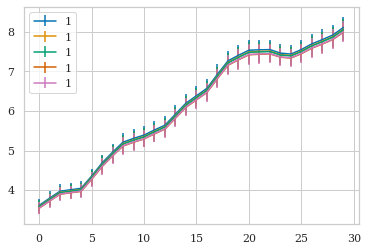

In [19]:
for nn in range(1, 2):
    plt.errorbar(xplot, pcapreds[nn].pred, pcapreds[nn].err, label=nn)
    plt.errorbar(xplot, pcapredsyj[nn].pred, pcapredsyj[nn].err, label=nn)
    plt.errorbar(xplot, pcapredsyjnoise[nn].pred, pcapredsyjnoise[nn].err, label=nn)
#     plt.errorbar(xplot, pcapredsyjnoisepca[nn].pred, pcapredsyjnoisepca[nn].err, label=nn)
    plt.errorbar(xplot, pcapredsreg[nn].pred, pcapredsreg[nn].err, label=nn)
    plt.errorbar(xplot, pcapredsregnoise[nn].pred, pcapredsregnoise[nn].err, label=nn)
#     plt.errorbar(xplot, pcapredsregnoisepca[nn].pred, pcapredsregnoisepca[nn].err, label=nn, ls="--")
    
plt.legend()

# KDE

0.16796748720926533
2 2


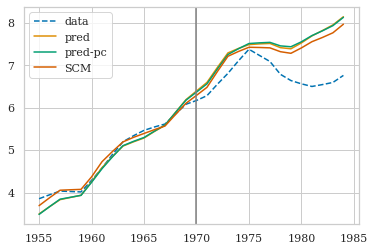

In [20]:
def get_ykde(gg, X1, X2, Y1, gamma=np.logspace(-3, 0, 1000), caty1=True):
    kde = KernelRegression(gg, gamma=gamma)
    kde.fit(X1, X2)
    if len(Y1.shape) <=1: Y1 =  Y1.reshape(1,-1)
    ykde, wts = kde.predict(Y1, retK=True)
    ykde0 = kde.predict(Y1, X1, retK=False)
    ykde = ykde.flatten()
    ykde0 = ykde0.flatten()
    if caty1 == 1: ykde = np.concatenate([Y1.flatten(), ykde])
    elif caty1 == 2: ykde = np.concatenate([ykde0, ykde]) 
    return ykde, kde, wts
 

ii = itreated
xxc = np.concatenate([X[:ii], X[ii+1:]])
yyc = X[ii]
means = xxc.mean(axis=0)*0
stds = xxc.std(axis=0)*0 + 1
xx = (xxc - means)/stds
yy = (yyc - means)/stds

##
X1 = xx[:, :T0]
X2 = xx[:, T0:]
Y1 = yy[:T0]
Y2 = yy[T0:]

#
yp, kde, wts = get_ykde('rbf', X1, X2, Y1, caty1=2)
print(kde.gamma)
yp *= stds
yp += means


plt.plot(years, yyc, '--', label='data')
plt.plot(years, yp, label='pred')
# plt.plot(years, means, 'k--', label='means')


nc1, nc2 = tools.approximate_rank(X1, 0.99), tools.approximate_rank(X2, 0.99)
if nc1 <=1 : nc1 +=1 
if nc2 <=1 : nc2 +=1 
print(nc1, nc2)
# nc1, nc2 = 3, 3 
p1, p2 = PCA(nc1, whiten=False).fit(X1), PCA(nc2, whiten=False).fit(X2)
XX1, XX2 = p1.transform(X1), p2.transform(X2)
YY1 = p1.transform(Y1.reshape(1,-1))
ykdep, kde, wts = get_ykde('rbf', XX1, XX2, YY1, caty1=2)
y1, y2 = ykdep[:nc1], ykdep[nc1:]
yp = np.concatenate([p1.inverse_transform(y1), p2.inverse_transform(y2)]) 
yp *= stds
yp += means
plt.plot(years, yp, label='pred-pc')

ypscm, wts = synth.fit(xx, yy, T0)
plt.plot(years, ypscm*stds + means, label='SCM')
plt.axvline(years[T0], color='gray')
plt.legend()

In [21]:
# KDE Fits without pre-processing
kdefitsvanilla =  {}
for ii, ss in enumerate(np.arange(N)):
    xxc = np.concatenate([X[:ii], X[ii+1:]])
    yyc = X[ii]
    means = xxc.mean(axis=0)*0
    stds = xxc.std(axis=0)*0 + 1
    xx = (xxc - means)/stds
    yy = (yyc - means)/stds
    ##
    X1 = xx[:, :T0]
    X2 = xx[:, T0:]
    Y1 = yy[:T0]
    Y2 = yy[T0:]
    yp, kde, wts = get_ykde('rbf', X1, X2, Y1,  caty1=2)
    yp *= stds
    yp += means
    kdefitsvanilla[ss] = GetObject(controls=xxc, treated=yyc, kde=kde, pred=yp, wts=wts)



## KDE FITS on he residual after subtracting mean

kdefitsres =  {}
for ii, ss in enumerate(np.arange(N)):
    xxc = np.concatenate([X[:ii], X[ii+1:]])
    yyc = X[ii]
    means = xxc.mean(axis=0)*0
    stds = xxc.std(axis=0)*0 + 1
    
    xx = (xxc - means)/stds
    mmx = xx[:, :T0].mean(axis=1).reshape(-1, 1)#(xxc - means)/stds
    xx = xx - mmx
    yy = (yyc - means)/stds
    mmy = yy[:T0].mean(axis=0)#(xxc - means)/stds
    yy -= mmy
    ##
    X1 = xx[:, :T0]
    X2 = xx[:, T0:]
    Y1 = yy[:T0]
    Y2 = yy[T0:]
    yp, kde, wts = get_ykde('rbf', X1, X2, Y1, caty1=2)
    yp +=  mmy
    yp *= stds
    yp += means
    kdefitsres[ss] = GetObject(controls=xxc, treated=yyc, kde=kde, pred=yp, wts=wts)

print('kdefitsres done')


## KDE FITS on he residual after subtracting mean and smoothing by using first couple PCs
kdefitsrespca =  {}
for ii, ss in enumerate(np.arange(N)):
    xxc = np.concatenate([X[:ii], X[ii+1:]])
    yyc = X[ii]
    means = xxc.mean(axis=0)*0
    stds = xxc.std(axis=0)*0 + 1
    
    xx = (xxc - means)/stds
    mmx = xx[:, :T0].mean(axis=1).reshape(-1, 1)#(xxc - means)/stds
    xx = xx - mmx
    yy = (yyc - means)/stds
    mmy = yy[:T0].mean(axis=0)#(xxc - means)/stds
    yy -= mmy
    ##
    nc = tools.approximate_rank(xx, 0.99)
    pca = PCA(nc).fit(xx)
    xx, yy = pca.inverse_transform(pca.transform(xx)), pca.inverse_transform(pca.transform(yy.reshape(1, -1)))
    yy = yy.flatten()

    X1 = xx[:, :T0]
    X2 = xx[:, T0:]
    Y1 = yy[:T0]
    Y2 = yy[T0:]
    yp, kde, wts = get_ykde('rbf', X1, X2, Y1, caty1=2)
    yp +=  mmy
    yp *= stds
    yp += means
    kdefitsrespca[ss] = GetObject(controls=xxc, treated=yyc, kde=kde, pred=yp, wts=wts)

print('kdefitsrespca99 done')

    
        

kdefitsres done
kdefitsrespca99 done


scmfits 0.6521917781668111
scmfitsres 0.5954710261714631
kdefits 0.7612927102706464
kdefitsres 0.6210744919956356
kdefitsrespca 0.5626825384067787


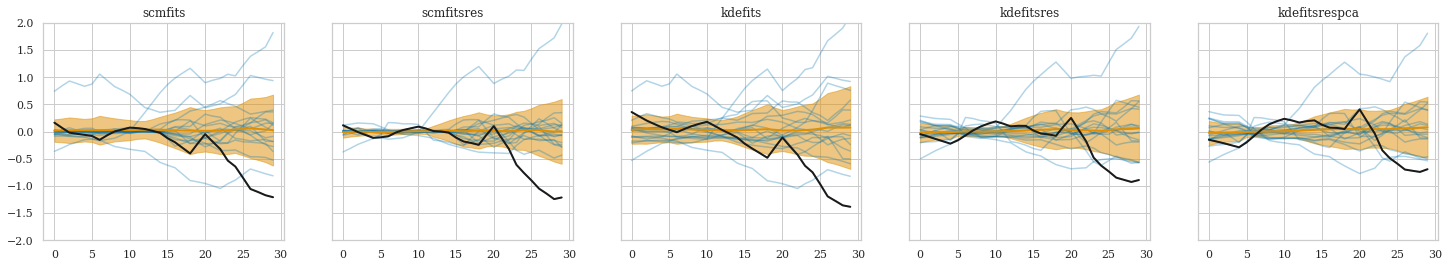

In [22]:
fig, ax = plt.subplots(1, 5, figsize=(25, 4), sharex=True, sharey=True)

xplot = np.arange(X.shape[1])

titles = ['scmfits', 'scmfitsres',  'kdefits', 'kdefitsres', 'kdefitsrespca']
for j, fits in enumerate([scmfits, scmfitsres, kdefitsvanilla, kdefitsres, kdefitsrespca]):
    tmp = []
    axis = ax.flatten()[j]
    for ii in range(X.shape[0]): 
        tmp.append(fits[ii].treated - fits[ii].pred)
        axis.plot(xplot, tmp[-1], 'C0', alpha=0.3)
    tmp = np.array(tmp)
    mmean, sstd = tmp.mean(axis=0), tmp.std(axis=0)
    print(titles[j], sstd[-1])
    axis.plot(xplot, mmean, 'C1', lw=2)
    axis.plot(xplot, tmp[itreated], 'k', lw=2)
    axis.fill_between(xplot, mmean - sstd, mmean + sstd, alpha=0.5, color='C1')
    axis.set_title(titles[j])
    axis.set_ylim(-2, 2)
#     axis.set_ylim(-50,50)

# GP

RBF(length_scale=2.04)


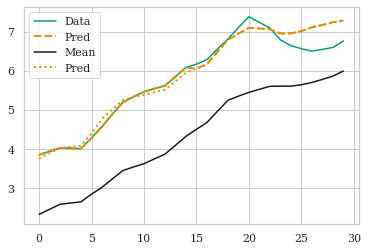

In [23]:
ii = itreated
xxc = np.concatenate([X[:ii], X[ii+1:]])
yyc = X[ii]
means = xxc.mean(axis=0)*1
stds = xxc.std(axis=0)*1# + 1
xx = (xxc - means)/stds
yy = (yyc - means)/stds

xxp = xx.copy()
gp = GPR(kernels.RBF(0.1), n_restarts_optimizer=100, alpha=0.01).fit(xxp[:, :T0], xxp[:, T0:])
print(gp.kernel_)
ypred = np.squeeze(gp.predict(yy[:T0].reshape(1, -1)))
ysample = np.squeeze(gp.sample_y(yy[:T0].reshape(1, -1), 100))        
yp = np.append(yyc[:T0], ypred*stds[T0:] + means[T0:])
ysample = np.squeeze(gp.sample_y(yy[:T0].reshape(1, -1), 100))        
ysample = ysample.T*stds[T0:]
err = np.append(np.zeros(T0), ysample.std(axis=0))

plt.plot(yyc, 'C2-', label='Data')
plt.plot(yp, 'C1--', label='Pred',lw=2)
# plt.plot(xxc.T, alpha=0.2, color='b')
plt.plot(means, color='k', label='Mean')

gpalpha = np.dot(np.linalg.inv(np.dot(gp.L_, gp.L_.T)), gp.y_train_)
gpkwts = gp.kernel_(gp.X_train_, yy[:T0].reshape(1, -1)).flatten()
wts = np.dot(gpkwts, np.linalg.inv(np.dot(gp.L_, gp.L_.T)))
pre = np.squeeze(np.dot(wts, gp.X_train_))
yp = np.append(pre, ypred)
yp *= stds
yp += means
plt.plot(yp, 'C1:', label='Pred',lw=2)
plt.legend()

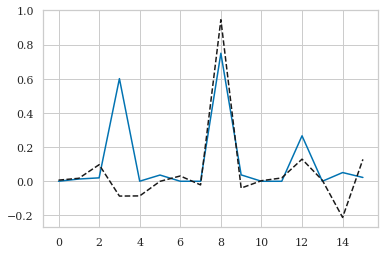

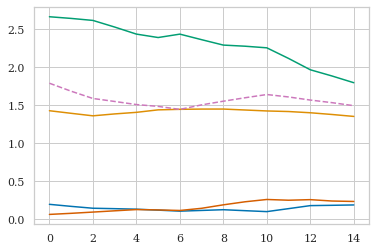

In [24]:
#Plot GP weights

plt.plot(gpkwts/(gpkwts**2).sum()**0.5)
plt.plot(wts/(wts**2).sum()**0.5, 'k--')
plt.show()
wtspos = np.where(wts > 0.1)[0]
plt.plot(gp.X_train_[wtspos].T)
plt.plot(yy[:T0], '--')

In [25]:
kernel = kernels.RBF
kernel = kernels.Matern

    
gpfits = {}
gpfitspca = {}

for ii, ss in enumerate(np.arange(N)):
    xxc = np.concatenate([X[:ii], X[ii+1:]])
    yyc = X[ii]
    means = xxc.mean(axis=0)
    stds = xxc.std(axis=0)*1# + 1
    xx = (xxc - means)/stds
    yy = (yyc - means)/stds

 
    def getgppca(ddict, ncomp):
            if ncomp is not None:
                if ncomp == xx.shape[0] or ncomp == T0: ncomp -=1
                pclpre = PCA(ncomp).fit(xx[:, :T0])
                xxpre = pclpre.inverse_transform(pclpre.transform(xx[:, :T0]))
                yypre = pclpre.inverse_transform(pclpre.transform(yy[:T0].reshape(1, -1))).flatten()
                xxpost = xx[:, T0:]
                yypost = yy[T0:]
                alpha = (xx[:, :T0] - xxpre).std(axis=1)
            else:
                xxpre, xxpost = xx[:, :T0].copy(), xx[:, T0:].copy()
                yypre, yypost = yy[:T0].copy(), yy[T0:].copy()
                alpha = xxpre.std(axis=1)/100.

        #     gp = GPR(kernels.RBF(1, [1e-1, 100]), n_restarts_optimizer=100, alpha=alpha).fit(xxpre, xxpost)
            gp = GPR(kernels.Matern(xxpre.std(axis=0), [xxpre.std()/100, xxpre.std()*100]), n_restarts_optimizer=100, alpha=alpha).fit(xxpre, xxpost)
            yp = np.squeeze(gp.predict(yypre.reshape(1, -1)))
            kwts = gp.kernel_(gp.X_train_, yy[:T0].reshape(1, -1)).flatten()
            wts = np.dot(kwts, np.linalg.pinv(np.dot(gp.L_, gp.L_.T)))
            yp = np.append(np.squeeze(np.dot(wts, gp.X_train_)), yp)
            yp = yp*stds + means
            ypred = (np.dot(wts, xx))*stds + means
            #
            ysample = np.squeeze(gp.sample_y(yypre.reshape(1, -1), 100))        
            ysample = ysample.T*stds[T0:]
            err = np.append(np.zeros(T0), ysample.std(axis=0))
#             if ncomp is not None:   ddict[ss] = GetObject(controls=xxc, treated=yyc, gp=gp, pred=ypred, predp=yp, err=err, pcapre=pclpre, pcapost=pclpost, wts=wts, kwts=kwts)
            if ncomp is not None:   ddict[ss] = GetObject(controls=xxc, treated=yyc, gp=gp, pred=ypred, predp=yp, err=err, pcapre=pclpre,  wts=wts, kwts=kwts)
            else: ddict[ss] = GetObject(controls=xxc, treated=yyc, gp=gp, pred=yp, err=err, wts=wts, kwts=kwts)
            
    getgppca(gpfits, None)    
#           
    ncomp = tools.approximate_rank(xx[:, :T0]-xx[:, :T0].mean(axis=0), thresh)
    getgppca(gpfitspca, ncomp)
    

    


In [26]:
   
gpfitsres = {}
gpfitspcares = {}

for ii, ss in enumerate(np.arange(N)):
    xxc = np.concatenate([X[:ii], X[ii+1:]])
    yyc = X[ii]
    means = xxc.mean(axis=0)*1
    stds = xxc.std(axis=0)*1 #+ 1
    xx = (xxc - means)/stds
    yy = (yyc - means)/stds
    mmx, mmy = xx[:, :T0].mean(axis=1).reshape(-1, 1), yy[:T0].mean()
    xx -= mmx
    yy -= mmy

    ####
#
    def getgppcares(ddict, ncomp):
            if ncomp is not None:
                if ncomp >= xx.shape[0] or ncomp >= xx.shape[1]: ncc = ncomp - 1
                else: ncc = ncomp
                pclpre = PCA(ncc).fit(xx[:, :T0])
                xxpre = pclpre.inverse_transform(pclpre.transform(xx[:, :T0]))
                yypre = pclpre.inverse_transform(pclpre.transform(yy[:T0].reshape(1, -1))).flatten()
#                 pclpost = PCA(ncc).fit(xx[:, T0:])
#                 xxpost = pclpost.inverse_transform(pclpost.transform(xx[:, T0:]))
#                 yypost = pclpost.inverse_transform(pclpost.transform(yy[T0:].reshape(1, -1))).flatten()
                xxpost = xx[:, T0:]
                yypost = yy[T0:]
                alpha = (xx[:, :T0] - xxpre).std(axis=1)
            else:
                xxpre, xxpost = xx[:, :T0].copy(), xx[:, T0:].copy()
                yypre, yypost = yy[:T0].copy(), yy[T0:].copy()
                alpha = xxpre.std(axis=1)/1000.
            #     gp = GPR(kernels.RBF(1, [1e-1, 100]), n_restarts_optimizer=100, alpha=alpha).fit(xxpre, xxpost)
            gp = GPR(kernels.Matern(xxpre.std(), [xxpre.std()/100, xxpre.std()*100]), n_restarts_optimizer=100, alpha=alpha).fit(xxpre, xxpost)
            yp = np.squeeze(gp.predict(yypre.reshape(1, -1)))
            kwts = gp.kernel_(gp.X_train_, yy[:T0].reshape(1, -1)).flatten()
            wts = np.dot(kwts, np.linalg.pinv(np.dot(gp.L_, gp.L_.T)))
            yp = np.append(np.squeeze(np.dot(wts, gp.X_train_)), yp)
            yp = (yp + mmy)*stds + means
            ypred = (np.dot(wts, xx) + mmy)*stds + means
            #
            ysample = np.squeeze(gp.sample_y(yypre.reshape(1, -1), 100))        
            ysample = ysample.T*stds[T0:]
            err = np.append(np.zeros(T0), ysample.std(axis=0))
            
#             if ncomp is not None:   ddict[ss] = GetObject(controls=xxc, treated=yyc, gp=gp, pred=ypred, predp=yp, err=err, pcapre=pclpre, pcapost=pclpost, wts=wts, kwts=kwts)
            if ncomp is not None:   ddict[ss] = GetObject(controls=xxc, treated=yyc, gp=gp, pred=ypred, predp=yp, err=err, pcapre=pclpre,  wts=wts, kwts=kwts, samples=ysample)
            else: ddict[ss] = GetObject(controls=xxc, treated=yyc, gp=gp, pred=yp, err=err, wts=wts, kwts=kwts)
            
            
    getgppcares(gpfitsres, None)
    
    ncomp = tools.approximate_rank(xx[:, :T0]-xx[:, :T0].mean(axis=0), thresh)
    getgppcares(gpfitspcares, ncomp)
    


/cm/shared/sw/pkg/devel/python3/3.7.3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.80261862e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 51, 'nit': 6, 'warnflag': 2}
  ConvergenceWarning)
/cm/shared/sw/pkg/devel/python3/3.7.3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.73678363e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 51, 'nit': 5, 'warnflag': 2}
  ConvergenceWarning)
/cm/shared/sw/pkg/devel/python3/3.7.3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.50560388e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 51, 'nit': 6, 'warnflag': 2}
  ConvergenceWarning)
/cm/shared/sw/pkg/devel/python3/3.7.3/lib/python3

scmres 0.5954710261714631
gp 0.7721438527909023
gp pca 0.7145022598996059
gpres 0.6018129481395618
gp res pca 0.5614823251287556


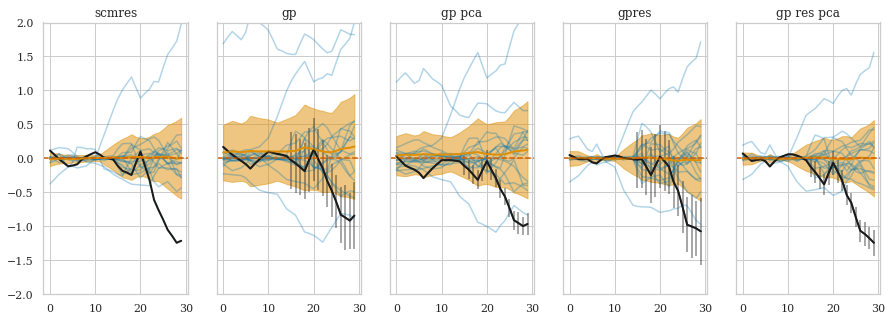

In [27]:

fig, ax = plt.subplots(1, 5, figsize=(15, 5), sharex=True, sharey=True)

xplot = np.arange(X.shape[1])
    
titles = ['scmres', 'gp', 'gp pca', 'gpres', 'gp res pca']
for j, fits in enumerate([scmfitsres, gpfits, gpfitspca, gpfitsres, gpfitspcares]):
    tmp = []
    axis = ax.flatten()[j]
    for ii in range(X.shape[0]): 
        tmp.append(fits[ii].treated - fits[ii].pred)
        axis.plot(xplot, tmp[-1], 'C0', alpha=0.3)
    tmp = np.array(tmp)
    mmean, sstd = tmp.mean(axis=0), tmp.std(axis=0)
    print(titles[j], sstd[-1])
    axis.plot(xplot, tmp[itreated], 'k', lw=2)
    try: axis.errorbar(xplot, tmp[itreated], fits[itreated].err, color='k', alpha=0.5)
    except: pass
    axis.plot(xplot, mmean, 'C1', lw=2)
    axis.fill_between(xplot, mmean - sstd, mmean + sstd, alpha=0.5, color='C1')
    axis.set_title(titles[j])
    axis.set_ylim(-2, 2)
#     axis.set_ylim(-50, 50)
    axis.axhline(0, color='r', ls="--")


# plot

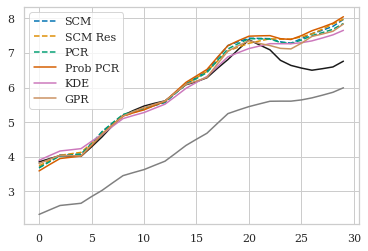

In [28]:
#Just plot the treated state for different methods 
plt.plot(scmfitsres[itreated].controls.mean(axis=0), 'gray')
plt.plot(scmfitsres[itreated].treated, 'k-')
plt.plot(scmfits[itreated].pred, '--', label='SCM')
plt.plot(scmfitsres[itreated].pred, '--', label='SCM Res')
plt.plot(pcafits[itreated].pred, '--', label='PCR')
plt.plot(pcafitsyj[itreated].pred, label='Prob PCR')
plt.plot(kdefitsres[itreated].pred, label='KDE')
plt.plot(gpfitsres[itreated].pred, label='GPR')
plt.legend()

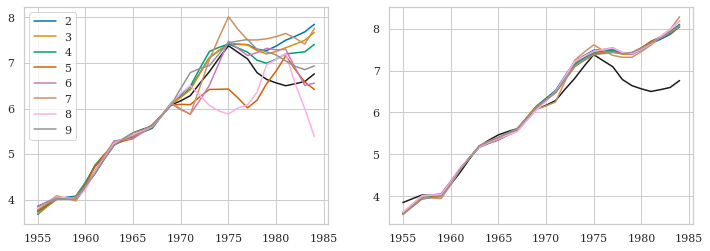

In [29]:
#Plot PCA regression for different number of components 

fig, ax = plt.subplots(1, 2, figsize = (12, 4))

ax[0].plot(years, treated, 'k')
for ncomp in range(2, 10):
    ax[0].plot(years, pcapreds[ncomp].pred, label=ncomp)
ax[0].legend()

ax[1].plot(years, treated, 'k')
for ncomp in range(2, 10):
    ax[1].plot(years, pcapredsyj[ncomp].pred)


0 0
1 1
2 1
3 2
4 2
5 3


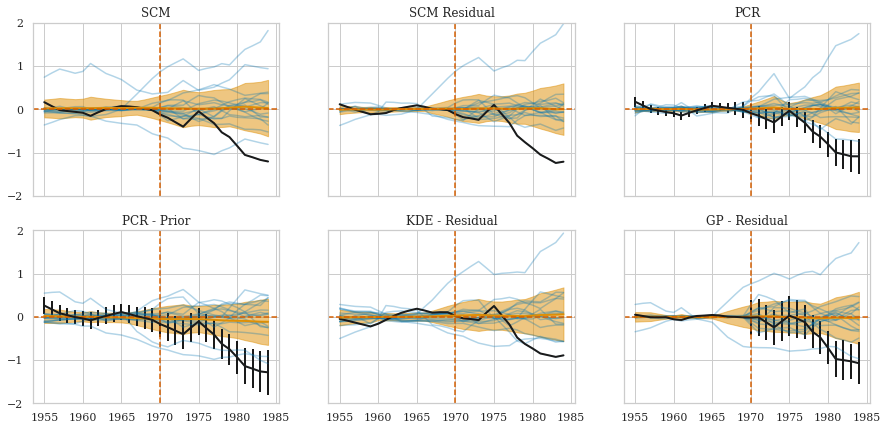

In [30]:
fig, ax = plt.subplots(2, 3, figsize=(15, 7), sharex=True, sharey=True)

xplot = years #np.arange(X.shape[1])
    
titles = ['SCM', 'SCM Residual', 'PCR',  'PCR - Prior', 'KDE - Residual',  'GP - Residual']
for j, fits in enumerate([scmfits,  scmfitsres, pcafits,  pcafitsyj, kdefitsres, gpfitsres]):

    tmp = []
    print(j, j//2 + j%2)
    axis = ax.flatten()[j]
    for ii in range(X.shape[0]): 
        tmp.append(fits[ii].treated - fits[ii].pred)
#         if i  : tmp[-1][:T0] *= 0
#         axis.plot(xplot, np.concatenate([tmp[-1][:T0]*0, tmp[-1][T0:]]), 'C0', alpha=0.3)
        axis.plot(xplot, tmp[-1], 'C0', alpha=0.3)
    tmp = np.array(tmp)
    mmean, sstd = tmp.mean(axis=0), tmp.std(axis=0)
    try: axis.errorbar(xplot, tmp[itreated], fits[itreated].err, color= 'k', lw=2)
    except:     axis.plot(xplot, tmp[itreated], 'k', lw=2)
    axis.plot(xplot, mmean, 'C1', lw=2)
    axis.fill_between(xplot, mmean - sstd, mmean + sstd, alpha=0.5, color='C1')
    axis.set_title(titles[j])
    axis.set_ylim(-2, 2)
#     axis.set_ylim(-100, 100)
    axis.axhline(0, color='r', ls="--")
    axis.axvline(years[T0], color='r', ls="--")
# plt.savefig('../new_figs/basque_all95.png')


# Save

In [31]:
# titles = ['scmfits','scmfitsres']
# for j, fits in enumerate([scmfits,  scmfitsres]):
#     tosave = np.array([[fits[ii].treated, fits[ii].pred] for ii in range(X.shape[0])])
#     np.save('../tmpdata/basque//%s'%titles[j], tosave)
    
# titles = 'pcafits95, pcafits99'
# titles = titles.split(', ')
# for j, fits in enumerate([pcafits95, pcafits99]):
#     try: tosave = np.array([[fits[ii].treated, fits[ii].pred, fits[ii].err] for ii in range(X.shape[0])])
#     except: 
#         print(titles[j])
#         tosave = np.array([[fits[ii].treated, fits[ii].pred] for ii in range(1, 11)])
#     np.save('../tmpdata/basque//%s'%titles[j], tosave)

# titles = 'glfits'
# titles = titles.split(', ')
# for j, fits in enumerate([glfits]):
#     try: tosave = np.array([[fits[ii].treated, fits[ii].pred, fits[ii].err] for ii in range(X.shape[0])])
#     except: 
#         print(titles[j])
#         tosave = np.array([[fits[ii].treated, fits[ii].pred] for ii in range(1, 11)])
#     np.save('../tmpdata/basque//%s'%titles[j], tosave)

# titles = 'pcafits95, pcafits99, pcafits95reg, pcafits99reg, pcafitsyj95, pcafitsyj99, pcafits95regnoise, pcafits99regnoise, pcafitsyj95noise, pcafitsyj99noise'
# titles = titles.split(', ')
# for j, fits in enumerate([pcafits95, pcafits99, pcafits95reg, pcafits99reg, pcafitsyj95, pcafitsyj99, pcafits95regnoise, pcafits99regnoise, pcafitsyj95noise, pcafitsyj99noise]):
#     try: tosave = np.array([[fits[ii].treated, fits[ii].pred, fits[ii].err] for ii in range(X.shape[0])])
#     except: 
#         print(titles[j])
#         tosave = np.array([[fits[ii].treated, fits[ii].pred] for ii in range(1, 11)])
#     np.save('../tmpdata/basque//%s'%titles[j], tosave)

    
# # titles = 'svdfits99, pcafits95, pcafits99, pcafits95reg, pcafits99reg, pcafitsyj95, pcafitsyj99, pcafits95regnoise, pcafits99regnoise, pcafitsyj95noise, pcafitsyj99noise'
# # titles = titles.split(', ')
# titles = 'pcafits95regnoisepca, pcafits99regnoisepca, pcafitsyj95noisepca, pcafitsyj99noisepca'
# titles = titles.split(', ')
# for j, fits in enumerate([pcafits95regnoisepca, pcafits99regnoisepca, pcafitsyj95noisepca, pcafitsyj99noisepca]):
#     try: tosave = np.array([[fits[ii].treated, fits[ii].pred, fits[ii].err] for ii in range(X.shape[0])])
#     except: 
#         print(titles[j])
#         tosave = np.array([[fits[ii].treated, fits[ii].pred] for ii in range(1, 11)])
#     np.save('../tmpdata/basque//%s'%titles[j], tosave)

# titles = 'kdefits, kdefitspca99, kdefitspcawts99, kdefitsres, kdefitsrespca99, kdefitsrespcawts99'
# titles = titles.split(', ')
# for j, fits in enumerate([kdefits, kdefitspca99, kdefitspcawts99, kdefitsres, kdefitsrespca99, kdefitsrespcawts99]):
#     tosave = np.array([[fits[ii].treated, fits[ii].pred] for ii in range(X.shape[0])])
#     np.save('../tmpdata/basque//%s'%titles[j], tosave)

# titles = 'gpfitspcawts99, gpfitspcawts99res'
# titles = titles.split(', ')
# for j, fits in enumerate([gpfitspcawts99, gpfitspcawts99res ]):
#     tosave = np.array([[fits[ii].treated, fits[ii].pred, fits[ii].err] for ii in range(X.shape[0])])
#     np.save('../tmpdata/basque//%s'%titles[j], tosave)    

# titles = 'gpfits, gpfitsres, gpfitspca99, gpfitspca99res, gpfitspca95, gpfitspca95res'
# titles = titles.split(', ')
# for j, fits in enumerate([gpfits, gpfitsres, gpfitspca99, gpfitspca99res, gpfitspca95, gpfitspca95res]):
#     tosave = np.array([[fits[ii].treated, fits[ii].pred, fits[ii].err] for ii in range(X.shape[0])])
#     np.save('../tmpdata/basque//%s'%titles[j], tosave)    


# titles = 'pcapreds, pcapredsreg, pcapredsyj, svdpreds, pcapredsregnoise, pcapredsyjnoise'
# titles = titles.split(', ')
# for j, fits in enumerate([pcapreds, pcapredsreg, pcapredsyj, svdpreds, pcapredsregnoise, pcapredsyjnoise]):
#     try: tosave = np.array([[fits[ii].treated, fits[ii].pred, fits[ii].err] for ii in range(1, 11)])
#     except: 
#         print(titles[j])
#         tosave = np.array([[fits[ii].treated, fits[ii].pred] for ii in range(1, 11)])
#     np.save('../tmpdata/basque//%s'%titles[j], tosave)    
